In [99]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import sklearn
from tqdm import tqdm_notebook
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout, Activation
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from 

In [104]:
cd = os.getcwd()
print(os.listdir(cd))
OUTPATH = os.chdir("C:\\Users\\ruire\\Documents\\GitHub\\Machine-learning-for-Finance")

['.git', '.ipynb_checkpoints', 'ge.us.txt', 'LSTM for stock prediction.ipynb', 'ML', 'Portfolio optimization', 'Q-learning', 'Real-time optimization.ipynb', 't-SNE algorithm for Finance.ipynb']


In [15]:
df = pd.read_csv("ge.us.txt", index_col = "Date", parse_dates = True, usecols = ["Date", "Open", "High", "Low", "Close", "Volume"])

In [32]:
df.tail()


,Open,High,Low,Close,Volume
Date,,,,,
2017-11-06,20.52,20.530,20.08,20.13,60641787
2017-11-07,20.17,20.250,20.12,20.21,41622851
2017-11-08,20.21,20.320,20.07,20.12,39672190
2017-11-09,20.04,20.071,19.85,19.99,50831779
2017-11-10,19.98,20.680,19.90,20.49,100698474


In [19]:
df.shape

(14058, 5)

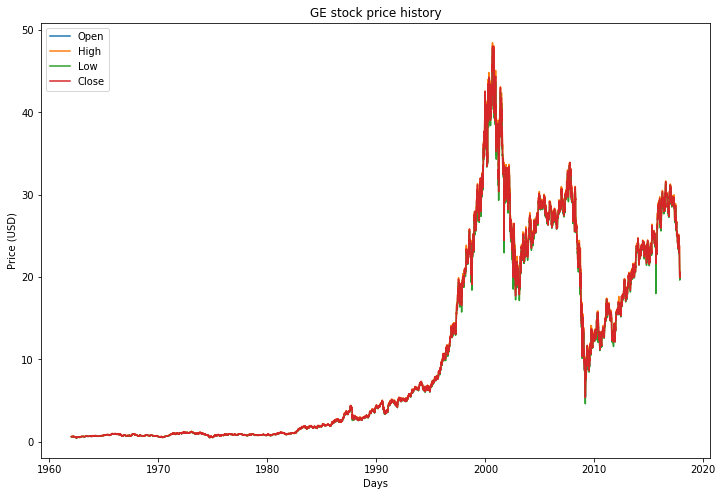

In [42]:
plt.figure(figsize = (12,8))
plt.plot(df["Open"].loc["2009-01-07":"2010-11-07"])
plt.plot(df["High"])
plt.plot(df["Low"])
plt.plot(df["Close"])
plt.title("GE stock price history")
plt.ylabel("Price (USD)")
plt.xlabel("Days")
plt.legend(["Open", "High", "Low", "Close"], loc = "upper left")

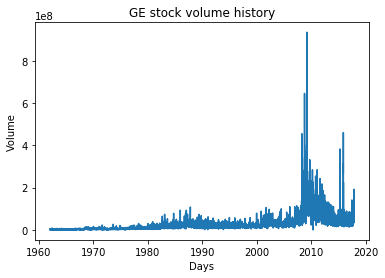

In [36]:
plt.figure()
plt.plot(df["Volume"])
plt.title("GE stock volume history")
plt.ylabel("Volume")
plt.xlabel("Days")
plt.show()

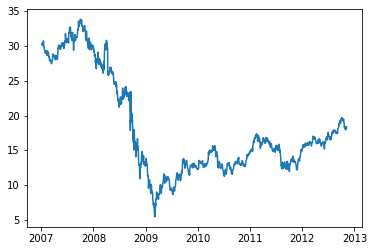

In [46]:
plt.plot(df["Open"].loc["2007-01-07":"2012-11-07"])

In [47]:
print("checking if any null values are present\n", df.isna().sum())

checking if any null values are present
 Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


## Normalizing the data

In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


In [54]:
train_cols = ["Open", "High", "Low", "Close", "Volume"]
df_train, df_test = train_test_split(df, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))

# scale the feature MinMax, build array

x = df_train.loc[:, train_cols].values
min_max_scaler = MinMaxScaler()

x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:, train_cols])

Train and Test size 11246 2812


In [55]:
x_train

array([[0.00356678, 0.00352766, 0.00358385, 0.00338425, 0.02108267],
       [0.00340607, 0.00319219, 0.00341628, 0.00338425, 0.01365459],
       [0.00340607, 0.00319219, 0.00323598, 0.00321827, 0.01758709],
       ...,
       [0.56738965, 0.56144866, 0.56900922, 0.56564471, 0.16041384],
       [0.56658613, 0.5678247 , 0.56695173, 0.57270398, 0.24217621],
       [0.57639752, 0.57292971, 0.57755734, 0.57677987, 0.25339457]])

In [56]:
x_test

array([[0.58098604, 0.57472167, 0.57944514, 0.57965821, 0.30279224],
       [0.57842746, 0.5750759 , 0.57959362, 0.57869176, 0.2306256 ],
       [0.58445385, 0.57740962, 0.583348  , 0.57984729, 0.3773507 ],
       ...,
       [0.4176391 , 0.41367433, 0.41613996, 0.41307201, 0.36092795],
       [0.41404441, 0.40848598, 0.41147349, 0.41034074, 0.46316191],
       [0.4127757 , 0.42117557, 0.41253405, 0.42084561, 0.91999503]])

##### Batch size 

1. How many samples of input do you want your Neural Network to see before updating the weights
2. big batch normal --> time consuming ---> less generalization

##### Time steps
1. define how many units back in time you want your network to see

##### Features
1. the number of the attributes used to repsent each time step

In [94]:
def build_timeseries(mat, y_col_index):
    TIME_STEPS = 60
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0))
    
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
        
    print("length of time-series i/o", x.shape, y.shape)
    return x, y

In [95]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that is divisible by Batch_size
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if no_of_rows_drop > 0:
        return mat[:-no_of_rows_drop]
    else:
        return mat
    

#### Train the model for the calculation

In [96]:
BATCH_SIZE = 20
x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)

x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_y = np.split(trim_dataset(x_temp, BATCH_SIZE), 2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE), 2)


length of time-series i/o (11186, 60, 5) (11186,)



length of time-series i/o (2752, 60, 5) (2752,)


## Create a model that would be perfect

In [111]:
def create_model():
    TIME_STEPS = 10
    lstm_model = Sequential()
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]), dropout=0.0, 
                        recurrent_dropout=0.0, stateful=True, kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(20, activation='relu'))
    lstm_model.add(Dense(1, activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=0.0001)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [112]:
csv_logger = CSVLogger(OUTPATH, append=True)
history = create_model.fit(x_t, y_t, epochs= 300, verbose=2, batch_size=BATCH_SIZE, shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[csv_logger])

AttributeError: 'function' object has no attribute 'fit'